In [178]:
# Loading required libraries

import datetime as dt
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings('ignore')

### Data Understanding

In [179]:
# Reading the given dataset as a dataframe

df = pd.read_excel('Data Science Assignment.xlsx', sheet_name='data')
df_dict = pd.read_excel('Data Science Assignment.xlsx', sheet_name='dictionary')

In [180]:
# Displaying first few rows

df.head()

,week,product,orders,brand,views,cart_adds,price,inventory
0,12/8/2019,A,41.0,Big Cable Brand,4181.0,209.0,34.99,158
1,12/15/2019,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122
2,12/22/2019,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71
3,12/29/2019,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33
4,1/5/2020,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0


In [181]:
# Data Dictionary

df_dict.style.set_properties(subset=['Description'], **{'width': '250px'})

,Variable,Description
0,week,Starting date of the week represented in MM/DD/YYYY
1,product,Name of the product
2,orders,Number of orders placed for that product in that week
3,brand,Brand of the product
4,views,Number of page views for the product
5,cart_adds,Number of customers who added the product to their cart
6,price,Price of the product listed for that week
7,inventory,Available inventory of the product at the end of that week


In [182]:
# The given data has 260 rows and 8 columns

df.shape

(260, 8)

### Data Pre-processing

##### Data types of columns

In [184]:
# The data type for the column 'week' has been read as string and needs to be changed to datetime type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   week       260 non-null    object 
 1   product    260 non-null    object 
 2   orders     259 non-null    float64
 3   brand      260 non-null    object 
 4   views      259 non-null    float64
 5   cart_adds  259 non-null    float64
 6   price      259 non-null    float64
 7   inventory  260 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 16.4+ KB


In [185]:
# Changing the week column to datetime type

df.week = pd.to_datetime(df.week)

##### Missing values 

In [187]:
# Few columns are having 1 missing value each and need to be treated

df.isna().sum()

week         0
product      0
orders       1
brand        0
views        1
cart_adds    1
price        1
inventory    0
dtype: int64

In [188]:
df[df['orders'].isna()]

,week,product,orders,brand,views,cart_adds,price,inventory
60,2020-02-02,B,NaN,Big Cable Brand,NaN,NaN,NaN,85


In [189]:
# Since the count of missing values is small, I will not be imputing it rather will drop such observations

df.dropna(inplace=True)

##### Inventory at start of the week

In [190]:
# Creating a column to get start of week inventory & dropping the first row for each product as it will have Null value

df['inv_sow'] = df.groupby(['product'])['inventory'].shift(1)
df.dropna(inplace=True)
df.head()

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow
1,2019-12-15,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122,158.0
2,2019-12-22,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71,122.0
3,2019-12-29,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33,71.0
4,2020-01-05,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0,33.0
5,2020-01-12,A,0.0,Big Cable Brand,2091.0,0.0,44.99,0,0.0


##### Inventory replenishment

In [191]:
# Creating a column to get the weekly replenishment

df['inv_rep'] = df.inventory + df.orders - df.inv_sow
df.head(10)

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep
1,2019-12-15,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122,158.0,0.0
2,2019-12-22,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71,122.0,0.0
3,2019-12-29,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33,71.0,0.0
4,2020-01-05,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0,33.0,0.0
5,2020-01-12,A,0.0,Big Cable Brand,2091.0,0.0,44.99,0,0.0,0.0
6,2020-01-19,A,0.0,Big Cable Brand,4476.0,0.0,29.99,0,0.0,0.0
7,2020-01-26,A,0.0,Big Cable Brand,1466.0,0.0,34.99,0,0.0,0.0
8,2020-02-02,A,0.0,Big Cable Brand,3829.0,0.0,54.99,0,0.0,0.0
9,2020-02-09,A,0.0,Big Cable Brand,3215.0,0.0,29.99,0,0.0,0.0
10,2020-02-16,A,20.0,Big Cable Brand,2823.0,58.0,54.99,142,0.0,162.0


##### Surplus inventory holding cost

In [192]:
# I am making an assumption that the surplus inventory(end of week) holding cost is 10% of the potential revenue
inv_hld_cst = 0.1

df['inv_cost'] = round(df.price*df.inventory*inv_hld_cst, 2)
df.head()

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep,inv_cost
1,2019-12-15,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122,158.0,0.0,365.88
2,2019-12-22,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71,122.0,0.0,212.93
3,2019-12-29,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33,71.0,0.0,82.47
4,2020-01-05,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0,33.0,0.0,0.00
5,2020-01-12,A,0.0,Big Cable Brand,2091.0,0.0,44.99,0,0.0,0.0,0.00


##### Product revenue

In [193]:
df['revenue'] = df.price*df.orders
df.head()

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep,inv_cost,revenue
1,2019-12-15,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122,158.0,0.0,365.88,1079.64
2,2019-12-22,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71,122.0,0.0,212.93,1529.49
3,2019-12-29,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33,71.0,0.0,82.47,949.62
4,2020-01-05,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0,33.0,0.0,0.00,1154.67
5,2020-01-12,A,0.0,Big Cable Brand,2091.0,0.0,44.99,0,0.0,0.0,0.00,0.00


##### Data type formatting

In [194]:
# using dictionary to convert specific columns 

convert_dict = {'orders': int, 
                'views': int,
                'cart_adds': int,
                'inv_sow': int,
                'inv_rep': int
               } 
  
df = df.astype(convert_dict)
df.head()

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep,inv_cost,revenue
1,2019-12-15,A,36,Big Cable Brand,3228,114,29.99,122,158,0,365.88,1079.64
2,2019-12-22,A,51,Big Cable Brand,5259,108,29.99,71,122,0,212.93,1529.49
3,2019-12-29,A,38,Big Cable Brand,3574,50,24.99,33,71,0,82.47,949.62
4,2020-01-05,A,33,Big Cable Brand,5970,66,34.99,0,33,0,0.00,1154.67
5,2020-01-12,A,0,Big Cable Brand,2091,0,44.99,0,0,0,0.00,0.00


### Exploratory Data Analysis

##### Price, Orders & Revenue trend for the 5 products

In [195]:
# Creating a function to subset data for a given product and not constrained by inventory

def trend(prd):
    return df[(df['orders']>0) & ((df['inv_sow'] + df['inv_rep'])>=df['orders']) & (df['product']==prd)]

# I have filtered out weeks where orders were zero or constrained due to inventory availability as these are not a true 
# representation of the product demand. 

[Text(0, 0.5, 'revenue ($)'), Text(0.5, 0, 'week')]

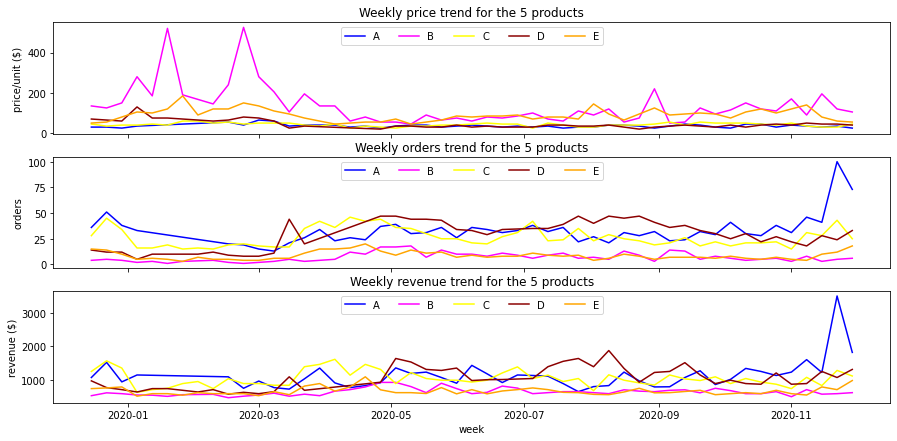

In [196]:
# Weekly price, orders & revenue trend for the 5 products

fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(15, 7))

ax1.plot(trend('A').week, trend('A').price, 'blue')
ax1.plot(trend('B').week, trend('B').price, 'magenta')
ax1.plot(trend('C').week, trend('C').price, 'yellow')
ax1.plot(trend('D').week, trend('D').price, 'darkred')
ax1.plot(trend('E').week, trend('E').price, 'orange')
ax1.legend(['A', 'B', 'C', 'D', 'E'], ncol=5, loc='upper center')
ax1.set_title('Weekly price trend for the 5 products')
ax1.set(ylabel='price/unit ($)')

ax2.plot(trend('A').week, trend('A').orders, 'blue')
ax2.plot(trend('B').week, trend('B').orders, 'magenta')
ax2.plot(trend('C').week, trend('C').orders, 'yellow')
ax2.plot(trend('D').week, trend('D').orders, 'darkred')
ax2.plot(trend('E').week, trend('E').orders, 'orange')
ax2.legend(['A', 'B', 'C', 'D', 'E'], ncol=5, loc='upper center')
ax2.set_title('Weekly orders trend for the 5 products')
ax2.set(ylabel='orders')

ax3.plot(trend('A').week, trend('A').revenue, 'blue')
ax3.plot(trend('B').week, trend('B').revenue, 'magenta')
ax3.plot(trend('C').week, trend('C').revenue, 'yellow')
ax3.plot(trend('D').week, trend('D').revenue, 'darkred')
ax3.plot(trend('E').week, trend('E').revenue, 'orange')
ax3.legend(['A', 'B', 'C', 'D', 'E'], ncol=5, loc='upper center')
ax3.set_title('Weekly revenue trend for the 5 products')
ax3.set(xlabel='week', ylabel='revenue ($)')

'''

Insights:

1. Product B & E have been more expensive throughout the year, and both had significant price swings
2. Even though prices for A, C & D tend to be steady(post Q1 2020), we see swings in quantity of orders, and this could be due to factors like seasonal demand peak, holiday sale etc.
3. Product A, C  & D were the major contributors to revenue throughout the year.

'''

##### Revenue(%) vs Orders(%) split among the 5 products

Text(0.5, 1.0, 'Orders(%) split among the 5 products')

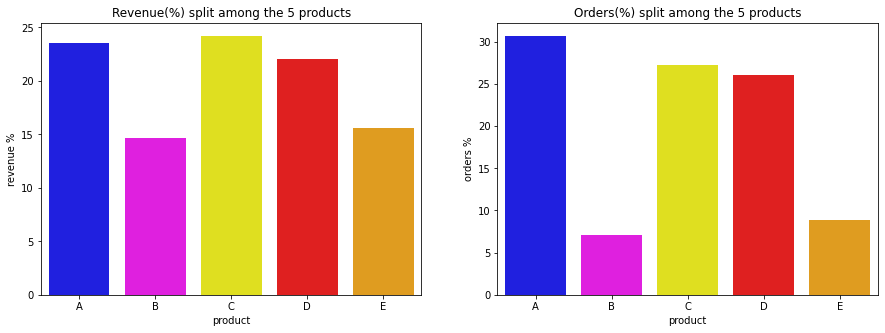

In [197]:
# Products A, C & D contribute approx 70% to the overall revenue but they account for approx 85% of total orders

df_rev = round(pd.pivot_table(df, index='product', values='revenue', aggfunc=np.sum)*100/sum(df.revenue),1)
df_rev.columns = ['revenue %']
df_rev.reset_index(inplace=True)

df_ord = round(pd.pivot_table(df, index='product', values='orders', aggfunc=np.sum)*100/sum(df.orders),1)
df_ord.columns = ['orders %']
df_ord.reset_index(inplace=True)

fig = plt.figure(figsize=(15, 5))
my_pal = {'A': 'blue', 'B': 'magenta', 'C': 'yellow', 'D': 'red', 'E': 'orange'}


ax = fig.add_subplot(1, 2, 1)
sns.barplot(x="product", y="revenue %", data=df_rev, palette=my_pal)
plt.title('Revenue(%) split among the 5 products')

ax = fig.add_subplot(1, 2, 2)
sns.barplot(x="product", y="orders %", data=df_ord, palette=my_pal)
plt.title('Orders(%) split among the 5 products')

'''

Insights:
1. Products A, C & D contribute approx 70% to the overall revenue and account for approx 85% of total orders
2. As the top performers, product A, C & D need more attention through better inventory control and avoiding stock-outs.
3. For prodcuts, B & E, stocking too much of these will result in unwanted inventory carrying costs.

'''


##### Inventory replenishment cycle for the 5 products

In [198]:
# Creating a function to subset data for a given product

def prd(prd):
    return df[df['product']==prd]

[Text(0, 0.5, 'count'), Text(0.5, 0, 'week')]

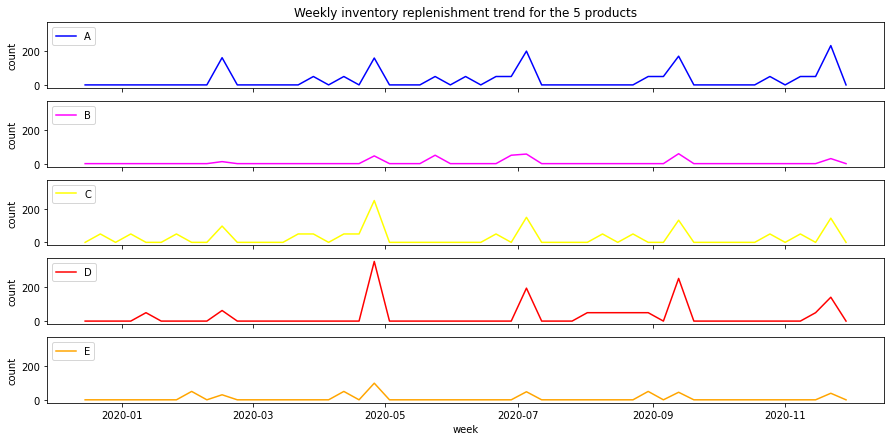

In [199]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, sharey=True, figsize=(15, 7))

ax1.plot(prd('A').week, prd('A').inv_rep, 'blue')
ax1.legend('A', loc='upper left')
ax1.set_title('Weekly inventory replenishment trend for the 5 products')
ax1.set(ylabel='count')

ax2.plot(prd('B').week, prd('B').inv_rep, 'magenta')
ax2.legend('B', loc='upper left')
ax2.set(ylabel='count')

ax3.plot(prd('C').week, prd('C').inv_rep, 'yellow')
ax3.legend('C', loc='upper left')
ax3.set(ylabel='count')

ax4.plot(prd('D').week, prd('D').inv_rep, 'red')
ax4.legend('D', loc='upper left')
ax4.set(ylabel='count')

ax5.plot(prd('E').week, prd('E').inv_rep, 'orange')
ax5.legend('E', loc='upper left')
ax5.set(xlabel='week', ylabel='count')

In [200]:
# Getting replenishment frequency, median, min & max quantity for the 5 products

df_inv_rep = pd.pivot_table(df[df.inv_rep>0], index='product', values='inv_rep', aggfunc=('count', 'median', 'max', 'min'))
df_inv_rep.rename(columns = {'count':'replenish_freq'}, inplace = True)
df_inv_rep[['replenish_freq', 'min', 'median', 'max']]
df_inv_rep

,replenish_freq,max,median,min
product,,,,
A,16,234,50,50
B,7,59,50,12
C,17,249,50,50
D,12,355,50,50
E,8,99,49,30


In [201]:
# Getting the weeks where peak inventory replensihment occured

pd.DataFrame(df[df.inv_rep>50]['week'].drop_duplicates()).set_index(np.array(range(1,6)))

,week
1,2020-02-16
2,2020-04-26
3,2020-07-05
4,2020-09-13
5,2020-11-22


'''

Insights

1. Products A, C & D had replensihment apporx. twice many times when compared to B & E 
2. The min & max replenishment quantity for A, C & D is significantly larger then that of B & E
3. During the above listed 5 weeks, all products had significantly larger replenishments, probably this was in anticipation of the seasonal demand peak and/or holiday sale cycle for these products.

'''

##### Surplus Inventory (end of week)

[Text(0, 0.5, 'count'), Text(0.5, 0, 'week')]

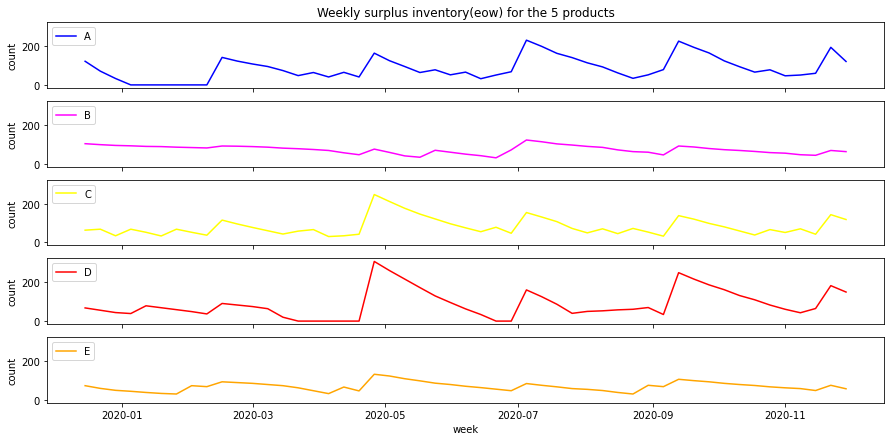

In [203]:
# Weekly surplus invetory(eow) trend for the 5 products

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, sharey=True, figsize=(15, 7))

ax1.plot(prd('A').week, prd('A').inventory, 'blue')
ax1.legend(['A'], loc='upper left')
ax1.set_title('Weekly surplus inventory(eow) for the 5 products')
ax1.set(ylabel='count')

ax2.plot(prd('B').week, prd('B').inventory, 'magenta')
ax2.legend(['B'], loc='upper left')
ax2.set(ylabel='count')

ax3.plot(prd('C').week, prd('C').inventory, 'yellow')
ax3.legend(['C'], loc='upper left')
ax3.set(ylabel='count')

ax4.plot(prd('D').week, prd('D').inventory, 'red')
ax4.legend(['D'], loc='upper left')
ax4.set(ylabel='count')

ax5.plot(prd('E').week, prd('E').inventory, 'orange')
ax5.legend(['E'], loc='upper left')
ax5.set(xlabel='week', ylabel='count')

In [204]:
# Surplus inventory holding cost
df_inv_cst = round(pd.pivot_table(df, index='product', values='inv_cost', aggfunc=np.sum, margins=True, margins_name='Total'))
df_inv_cst.rename(columns={'inv_cost':'surplus_inv_cost($)'}, inplace=True)

df_inv_cst2 = round(df_inv_cst.rename(columns={'surplus_inv_cost($)':'surplus_inv_cost(%)'})*100/sum(df.inv_cost))
df_inv_cst.join(df_inv_cst2)

,surplus_inv_cost($),surplus_inv_cost(%)
product,,
A,15866.0,12.0
B,52276.0,39.0
C,16836.0,13.0
D,18652.0,14.0
E,30871.0,23.0
Total,134501.0,100.0


'''

Insight:
1. For most part of the year, products A, C & D have maintained more end of week inventory then B & E.
2. Even though B & E had lower inventory, but they contributed over 60% towards the inventory holding cost.
3. This is an area that needs improvement, a better inventory forecast can help in bringing down the overall inventory holding cost.

'''

##### Revenue lost due to unavailable/limited Inventory

In [205]:
# Weeks with zero orders due to inventory stockout

df[df.orders==0]

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep,inv_cost,revenue
5,2020-01-12,A,0,Big Cable Brand,2091,0,44.99,0,0,0,0.0,0.0
6,2020-01-19,A,0,Big Cable Brand,4476,0,29.99,0,0,0,0.0,0.0
7,2020-01-26,A,0,Big Cable Brand,1466,0,34.99,0,0,0,0.0,0.0
8,2020-02-02,A,0,Big Cable Brand,3829,0,54.99,0,0,0,0.0,0.0
9,2020-02-09,A,0,Big Cable Brand,3215,0,29.99,0,0,0,0.0,0.0
172,2020-03-29,D,0,Little Cable Brand,4338,0,19.99,0,0,0,0.0,0.0
173,2020-04-05,D,0,Little Cable Brand,7615,0,24.99,0,0,0,0.0,0.0
174,2020-04-12,D,0,Little Cable Brand,5764,0,19.99,0,0,0,0.0,0.0
175,2020-04-19,D,0,Little Cable Brand,2771,0,34.99,0,0,0,0.0,0.0
185,2020-06-28,D,0,Little Cable Brand,2746,0,44.99,0,0,0,0.0,0.0


'''

Insights:
1. Products A & D had zero orders for 5 weeks each.
2. There was no inventory at start of week and neither there were any replenishment, resulting in zero orders.
3. This is potential revenue loss due to unavailability of in-demand products and needs better inventory planning.

'''

In [206]:
# Weeks where orders were constrained due to limited inventory

df[(df.orders>0) & ((df.inv_sow + df.inv_rep)==df.orders)]

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep,inv_cost,revenue
4,2020-01-05,A,33,Big Cable Brand,5970,66,34.99,0,33,0,0.0,1154.67
171,2020-03-22,D,20,Little Cable Brand,9138,91,34.99,0,20,0,0.0,699.80
184,2020-06-21,D,34,Little Cable Brand,1547,66,29.99,0,34,0,0.0,1019.66


'''

Insights

1. There were 3 weeks for products A & D when the orders were same as the available inventory(start of week).
2. Interestingly both A & D were having substantial views & cart adds, signifying demand among the consumers.
3. Its possible that we could have seen more orders if additional inventory was available for those weeks.

'''

##### Estimating Revenue lost due to unavailable Inventory

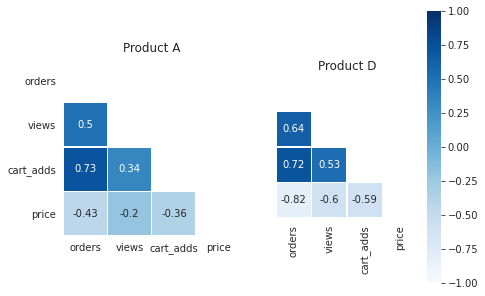

In [208]:
# Correlation between orders, views & cart adds for products A & D

df_corr_A = round(trend('A')[['orders', 'views', 'cart_adds', 'price']].corr(),2)
df_corr_D = round(trend('D')[['orders', 'views', 'cart_adds', 'price']].corr(),2)

mask = np.zeros_like(df_corr_A)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(7, 5))
    sns.heatmap(df_corr_A, mask=mask, vmin=-1, vmax=1, square=True, annot=True, linewidths=.5, cmap=plt.cm.Blues, ax=ax[0], cbar=False)
    ax[0].set_title('Product A')
    sns.heatmap(df_corr_D, mask=mask, vmin=-1, vmax=1, square=True, annot=True, linewidths=.5, cmap=plt.cm.Blues, ax=ax[1], cbar=True)
    ax[1].set_title('Product D')

### Order prediction model

In [209]:
# Function to build a random forest regression model to predict orders based on views, cart adds & price of the product

def ord_pred(prd):
    
    # Getting the product data for model building
    df_rf = trend(prd)[['orders', 'views', 'cart_adds', 'price']]    
    
    # Seperating the Y-variable i.e. orders from the X-variables i.e predictors
    X = df_rf.drop(['orders'], axis=1)
    Y = df_rf['orders']

    # Splitting data into train & test
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.2, random_state=123)
    
    # Instantiate model with 3 decision trees
    rf = RandomForestRegressor(n_estimators=3, max_depth=5, random_state = 123)

    # Train the model on training data
    rf.fit(X_train , Y_train)

    # Use the predict method on the test data
    predictions = np.round(rf.predict(X_test))

    # Calculate the absolute errors
    errors = abs(predictions - Y_test)

    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors), 2))

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / Y_test)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    #print('Order prediction accuracy for product',prd,':', round(accuracy, 2), '%')
    
    return rf

##### Predicting orders for the weeks with zero orders

###### Product A

In [210]:
# Getting data for weeks with zero orders
df_ord_pred_A = df[(df.orders==0) & (df['product']=='A')]

# Getting the predicted orders for those weeks
df_ord_pred_A['ord_pred'] = ord_pred('A').predict(df_ord_pred_A[['views', 'cart_adds', 'price']])
df_ord_pred_A['ord_pred'] = df_ord_pred_A['ord_pred'].astype('int')

# Getting the possible revenue lost for those weeks
df_ord_pred_A['rev_lost'] = df_ord_pred_A['ord_pred'] * df_ord_pred_A['price']
df_ord_pred_A[['week', 'product', 'views', 'cart_adds', 'price', 'ord_pred', 'rev_lost']]

,week,product,views,cart_adds,price,ord_pred,rev_lost
5,2020-01-12,A,2091,0,44.99,27,1214.73
6,2020-01-19,A,4476,0,29.99,36,1079.64
7,2020-01-26,A,1466,0,34.99,29,1014.71
8,2020-02-02,A,3829,0,54.99,16,879.84
9,2020-02-09,A,3215,0,29.99,32,959.68


In [211]:
# Potential revenue lost

round(sum(df_ord_pred_A.rev_lost))

5149

###### Product D

In [212]:
# Getting data for weeks with zero orders
df_ord_pred_D = df[(df.orders==0) & (df['product']=='D')]

# Getting the predicted orders for those weeks
df_ord_pred_D['ord_pred'] = ord_pred('D').predict(df_ord_pred_D[['views', 'cart_adds', 'price']])
df_ord_pred_D['ord_pred'] = df_ord_pred_D['ord_pred'].astype('int')

# Getting the possible revenue lost for those weeks
df_ord_pred_D['rev_lost'] = df_ord_pred_D['ord_pred'] * df_ord_pred_D['price']
df_ord_pred_D[['week', 'product', 'views', 'cart_adds', 'price', 'ord_pred', 'rev_lost']]

,week,product,views,cart_adds,price,ord_pred,rev_lost
172,2020-03-29,D,4338,0,19.99,33,659.67
173,2020-04-05,D,7615,0,24.99,33,824.67
174,2020-04-12,D,5764,0,19.99,33,659.67
175,2020-04-19,D,2771,0,34.99,30,1049.70
185,2020-06-28,D,2746,0,44.99,30,1349.70


In [213]:
# Potential revenue lost

round(sum(df_ord_pred_D.rev_lost))

4543

### Timeseries model

In [214]:
# Creating dataset with the predicted orders for A & D for the 10 weeks which originally had zero orders

df_ts = pd.merge(df, df_ord_pred_A[['week', 'product', 'ord_pred']], on=['week', 'product'], how='left')
df_ts['ord_ts'] = list(map(lambda x,y: x if pd.isna(y) else y, df_ts.orders, df_ts.ord_pred))
df_ts = df_ts.drop('ord_pred', axis=1)

df_ts = pd.merge(df_ts, df_ord_pred_D[['week', 'product', 'ord_pred']], on=['week', 'product'], how='left')
df_ts['ord_ts'] = list(map(lambda x,y: x if pd.isna(y) else y, df_ts.ord_ts, df_ts.ord_pred))
df_ts['ord_ts'] = df_ts['ord_ts'].astype('int')
df_ts = df_ts.drop('ord_pred', axis=1)

# Calculating revenue loss for the 10 weeks
df_ts['rev_loss'] = list(map(lambda x, y, z : z*y if x==0 else 0, df_ts.orders, df_ts.ord_ts, df_ts.price))
df_ts.head()

,week,product,orders,brand,views,cart_adds,price,inventory,inv_sow,inv_rep,inv_cost,revenue,ord_ts,rev_loss
0,2019-12-15,A,36,Big Cable Brand,3228,114,29.99,122,158,0,365.88,1079.64,36,0.00
1,2019-12-22,A,51,Big Cable Brand,5259,108,29.99,71,122,0,212.93,1529.49,51,0.00
2,2019-12-29,A,38,Big Cable Brand,3574,50,24.99,33,71,0,82.47,949.62,38,0.00
3,2020-01-05,A,33,Big Cable Brand,5970,66,34.99,0,33,0,0.00,1154.67,33,0.00
4,2020-01-12,A,0,Big Cable Brand,2091,0,44.99,0,0,0,0.00,0.00,27,1214.73


##### Prophet model

In [215]:
def ts_mdl(prd):
    
    # Subseting the data for a product
    df_mdl = df_ts[df_ts['product']==prd]
    
    # Prophet requires the variable names in the time series to be:
    # y – Target
    # ds – Datetime
    df_mdl.rename(columns = {'week':'ds', 'ord_ts':'y'}, inplace = True)
    df_mdl = df_mdl[['ds', 'y', 'brand']]
    df_mdl['brand'] = list(map(lambda x: 1 if x=="Big Cable Brand" else 0, df_mdl['brand']))
    
    # Timeseries model
    tsm = Prophet(changepoint_prior_scale=0.5, weekly_seasonality=True)
    tsm.add_country_holidays(country_name='CA')
    tsm.add_regressor('brand')
    
    # Doing the forecast
    forecast = tsm.fit(df_mdl).predict(df_mdl[['ds', 'brand']])
    
    # Merging the forecasted values with original data
    d1 = df_ts[df_ts['product']==prd].drop(['brand', 'views', 'cart_adds', 'inv_rep'], axis=1)
    d2 = forecast[['ds', 'yhat']]
    df_merg = pd.merge(d1, d2, left_on='week', right_on='ds', how='inner')
    df_merg.drop(['ds'], axis=1, inplace=True)
    
    # Renaming yhat column to inventory start of week predicted
    df_merg['yhat'] = df_merg['yhat'].astype('int')
    df_merg.rename(columns = {'yhat':'inv_sow_pred'}, inplace=True)
    
    # Calculating predicted inventory end of week and its cost
    df_merg['inv_eow_pred'] = list(map(lambda x, y : x-y if x>y else 0, df_merg.inv_sow_pred, df_merg.ord_ts))
    df_merg['inv_cost_pred'] = round(df_merg.price*df_merg.inv_eow_pred*inv_hld_cst, 2)
    
    # Calculating potential revenue loss if the forecasted inventory results in a shortfall
    df_merg['rev_loss_pred'] = list(map(lambda x, y, z : z*(y-x) if x<y else 0, df_merg.inv_sow_pred, df_merg.ord_ts, df_merg.price))

    # Calculating potential saving in inventory cost
    df_sav = pd.pivot_table(df_merg, index='product', values=['inv_cost', 'rev_loss', 'inv_cost_pred', 'rev_loss_pred'], aggfunc=np.sum).astype('int')
    df_sav['potential_saving'] = (df_sav.inv_cost + df_sav.rev_loss) - (df_sav.inv_cost_pred + df_sav.rev_loss_pred)
    #df_sav.reset_index(inplace=True)
    df_sav
    
    return df_sav, df_merg

In [219]:
# Holidays considered in the model

#pd.DataFrame(tsm.train_holiday_names, columns=['Canada Holidays'])

,Canada Holidays
0,New Year's Day
1,Family Day
2,Good Friday
3,Victoria Day
4,Canada Day
5,Civic Holiday
6,Labour Day
7,Thanksgiving
8,Christmas Day
9,Boxing Day


In [223]:
# Calculating the potential savings for all the products

df_op = pd.DataFrame()

for prd in ['A', 'B', 'C', 'D', 'E']:
    df_op = df_op.append(ts_mdl(prd)[0])

df_op

,inv_cost,inv_cost_pred,rev_loss,rev_loss_pred,potential_saving
product,,,,,
A,15865,599,5148,5453,14961
B,52275,952,0,5254,46069
C,16836,821,0,6508,9507
D,18652,672,4543,5128,17395
E,30871,659,0,4559,25653


In [224]:
# Total potential savings

pd.DataFrame(df_op.sum(axis=0)).transpose()

,inv_cost,inv_cost_pred,rev_loss,rev_loss_pred,potential_saving
0,134499,3703,9691,26902,113585
